In [1]:
import import_ipynb

In [2]:
%run iteration_0_imports.py

In [3]:
%run iteration_0_parameters.py

In [4]:
import iteration_0_utils as utils

importing Jupyter notebook from iteration_0_utils.ipynb


In [5]:
%whos

Variable                          Type        Data/Info
-------------------------------------------------------
HEALTHY                           str         H
IMG_IN_COLOR                      int         1
IMG_SIZE                          int         64
Image                             module      <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
NBR_SAMPLE                        int         20000
PATH_DATA                         str         ../data
PATH_DATA_EDA                     str         ../data/eda
PATH_DATA_LIST                    str         ../data/list
PATH_DATA_SAMPLE                  str         ../data/sample
PATH_MODEL                        str         ../model
PATH_ROOT                         str         ..
PATH_SOURCE_IMG                   str         ../cell_images
RandomForestClassifier            ABCMeta     <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SICK                              str         S
classification_report             function

# make X, y

In [6]:
DATE_TIME = "2021-11-18_20-39-00"

In [7]:
# get list 
list_path_sample_img = []
list_path_sample_img.extend(glob.glob(PATH_DATA_SAMPLE+"/"+DATE_TIME+ "/"+ "*.pklz"))

In [8]:
# split train, validation, test set
list_path_sample_img_train, list_path_sample_img_test  = train_test_split(list_path_sample_img, test_size=0.2)
list_path_sample_img_train, list_path_sample_img_valid = train_test_split(list_path_sample_img_train, test_size=0.2)

In [9]:
def make_Xy(list_path_sample_img: list) -> (np.array, np.array):
    X = np.ndarray( (len(list_path_sample_img), IMG_SIZE, IMG_SIZE, 3) ,dtype = "float16")
    y = np.array([""] * len(list_path_sample_img))
    for i, path in tqdm(enumerate(list_path_sample_img)):
        
        X[i] = utils.pickle_read(path).astype("float16")
    
        _, file_name, _ = utils.split_file_info(path)
        y[i] = file_name[0]
    
    return X, y
    

In [10]:
X_train, y_train  = make_Xy(list_path_sample_img_train)

12800it [03:29, 61.18it/s]


In [11]:
X_valid, y_valid  = make_Xy(list_path_sample_img_valid)

3200it [00:49, 64.50it/s]


In [12]:
X_test, y_test  = make_Xy(list_path_sample_img_test)

4000it [01:04, 61.54it/s]


# model_cnn

* Ref: https://towardsdatascience.com/detecting-malaria-with-deep-learning-9e45c1e34b60
* https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d

In [138]:
BATCH_SIZE = 500
NUM_CLASSES = 2
EPOCHS = 15
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [49]:
# Encoder y
from sklearn.preprocessing import LabelEncoder

In [139]:
le = LabelEncoder()

In [140]:
y_train_enc = le.fit_transform(y_train)

In [141]:
y_valid_enc = le.transform(y_valid)
y_test_enc  = le.transform(y_test)

In [142]:
le.classes_

array(['H', 'S'], dtype='<U1')

In [143]:
import tensorflow as tf

In [144]:
from keras.models import Sequential

In [145]:
model_cnn = Sequential()
model_cnn.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))
model_cnn.add(tf.keras.layers.Conv2D(name = "conv2D",
                                     filters=32,
                                     kernel_size=(3,3),
                                     activation="LeakyReLU",
                                     padding="same",
                                     kernel_initializer="he_uniform"
                                    ))
model_cnn.add(tf.keras.layers.MaxPooling2D(name="pooling", pool_size=(2,2)))
model_cnn.add(tf.keras.layers.Flatten(name="flatten"))
model_cnn.add(tf.keras.layers.Dense(name="dense_hidden", units = 256, activation="LeakyReLU",
                                    kernel_initializer="he_uniform" ))
model_cnn.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))


In [146]:
# compiler modele
model_cnn.compile(optimizer = "adam", loss ="binary_crossentropy", metrics=["accuracy"])

In [147]:
model_cnn.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense_hidden (Dense)         (None, 256)               8388864   
_________________________________________________________________
ouput (Dense)                (None, 1)                 257       
Total params: 8,390,017
Trainable params: 8,390,017
Non-trainable params: 0
_________________________________________________________________


In [148]:
from keras.callbacks import EarlyStopping

In [149]:
# es = EarlyStopping(mode='min', monitor='val_loss')

In [150]:
history = model_cnn.fit(X_train, y_train_enc, epochs=EPOCHS, validation_data=(X_valid, y_valid_enc), batch_size = BATCH_SIZE,
                        )

Epoch 1/15
26/26 [==============================] - 66s 2s/step - loss: 6.2456 - accuracy: 0.5558 - val_loss: 2.5559 - val_accuracy: 0.5691
Epoch 2/15
26/26 [==============================] - 55s 2s/step - loss: 1.1429 - accuracy: 0.6381 - val_loss: 0.7312 - val_accuracy: 0.6469
Epoch 3/15
26/26 [==============================] - 55s 2s/step - loss: 0.6012 - accuracy: 0.6894 - val_loss: 0.5922 - val_accuracy: 0.6888
Epoch 4/15
26/26 [==============================] - 55s 2s/step - loss: 0.5634 - accuracy: 0.7130 - val_loss: 0.6763 - val_accuracy: 0.6356
Epoch 5/15
26/26 [==============================] - 54s 2s/step - loss: 0.6113 - accuracy: 0.6899 - val_loss: 0.6877 - val_accuracy: 0.6463
Epoch 6/15
26/26 [==============================] - 57s 2s/step - loss: 0.5839 - accuracy: 0.7026 - val_loss: 0.7075 - val_accuracy: 0.6288
Epoch 7/15
26/26 [==============================] - 58s 2s/step - loss: 0.6598 - accuracy: 0.6840 - val_loss: 0.7586 - val_accuracy: 0.6313
Epoch 8/15
26/26 [==

In [158]:
history.history

{'loss': [6.245577335357666,
  1.1429164409637451,
  0.6012476086616516,
  0.5633777976036072,
  0.6113153100013733,
  0.5838627815246582,
  0.6597861647605896,
  0.5706486701965332,
  0.5401079058647156,
  0.5093961954116821,
  0.6239539980888367,
  0.4772053062915802,
  0.5127290487289429,
  0.45049813389778137,
  0.4681810736656189],
 'accuracy': [0.5557812452316284,
  0.6381250023841858,
  0.6893749833106995,
  0.7129687666893005,
  0.6899218559265137,
  0.7025781273841858,
  0.6839843988418579,
  0.7167187333106995,
  0.7333593964576721,
  0.7572656273841858,
  0.6949218511581421,
  0.778515636920929,
  0.7515624761581421,
  0.7966406345367432,
  0.7810937762260437],
 'val_loss': [2.5558669567108154,
  0.7311764359474182,
  0.5921860337257385,
  0.6763321757316589,
  0.6876797676086426,
  0.7075080275535583,
  0.7585574388504028,
  0.6147882342338562,
  0.5748110413551331,
  0.7745088338851929,
  0.6327125430107117,
  0.6787801384925842,
  0.570412814617157,
  0.5630914568901062,


In [157]:
print(model_cnn.metrics_names)

['loss', 'accuracy']


In [206]:
def plot_history(history):
    plt.figure(figsize=(16,9))
    # plot loss
    plt.subplot(211)
    plt.grid()
    plt.title('binary_crossentropy')
    plt.plot(history.history['loss'], "o-", color='blue', label='train')
    plt.plot(history.history['val_loss'], "o-", color='orange', label='validation')
    plt.legend()    
    # plot accuracy
    plt.subplot(212)
    plt.grid()
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], "o-",color='blue', label='train')
    plt.plot(history.history['val_accuracy'], "o-",color='orange', label='validation')
    plt.legend()
    plt.show()

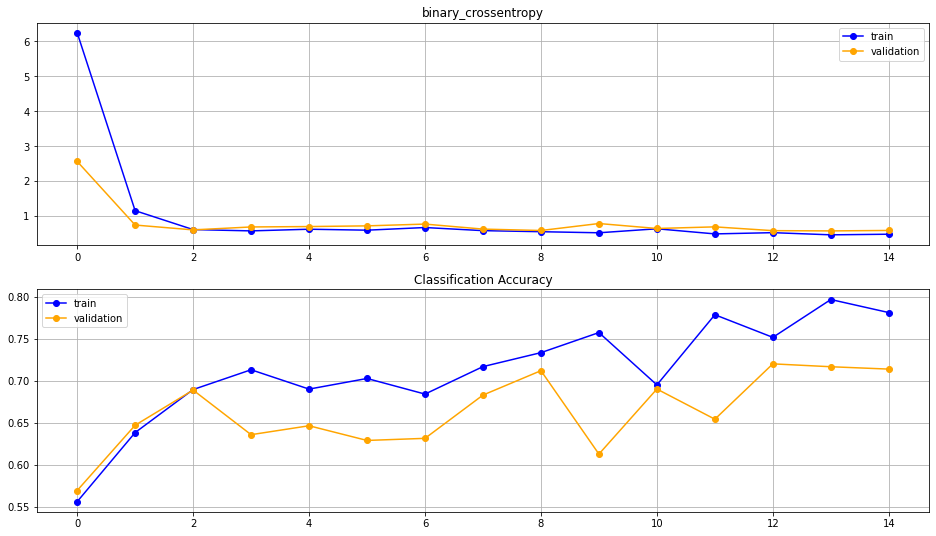

In [207]:
plot_history(history)

In [170]:
model_cnn_2 = Sequential()
model_cnn_2.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))
model_cnn_2.add(tf.keras.layers.Conv2D(name = "conv2D",
                                     filters=32,
                                     kernel_size=(3,3),
                                     activation="LeakyReLU",
                                     padding="same",
                                     kernel_initializer="he_uniform"
                                    ))
model_cnn_2.add(tf.keras.layers.MaxPooling2D(name="pooling", pool_size=(2,2)))
model_cnn_2.add(tf.keras.layers.Conv2D(name = "conv2D_2",
                                     filters=64,
                                     kernel_size=(3,3),
                                     activation="LeakyReLU",
                                     padding="same",
                                     kernel_initializer="he_uniform"
                                    ))
model_cnn_2.add(tf.keras.layers.MaxPooling2D(name="pooling_2", pool_size=(2,2)))
model_cnn_2.add(tf.keras.layers.Flatten(name="flatten"))
model_cnn_2.add(tf.keras.layers.Dense(name="dense_hidden", units = 256, activation="LeakyReLU",
                                    kernel_initializer="he_uniform" ))
model_cnn_2.add(tf.keras.layers.Dense(name="dense_hidden_2", units = 128, activation="LeakyReLU",
                                    kernel_initializer="he_uniform" ))
model_cnn_2.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))


In [171]:
# compiler modele
model_cnn_2.compile(optimizer = "adam", loss ="binary_crossentropy", metrics=["accuracy"])

In [172]:
model_cnn_2.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 32, 32, 32)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense_hidden (Dense)         (None, 256)               4194560   
_________________________________________________________________
dense_hidden_2 (Dense)       (None, 128)             

In [173]:
history_2 = model_cnn_2.fit(X_train, y_train_enc, epochs=EPOCHS, validation_data=(X_valid, y_valid_enc), batch_size = BATCH_SIZE,
                        )

Epoch 1/15
26/26 [==============================] - 92s 3s/step - loss: 1.8322 - accuracy: 0.5441 - val_loss: 0.6237 - val_accuracy: 0.6609
Epoch 2/15
26/26 [==============================] - 87s 3s/step - loss: 0.5979 - accuracy: 0.6813 - val_loss: 0.5883 - val_accuracy: 0.7006
Epoch 3/15
26/26 [==============================] - 88s 3s/step - loss: 0.5639 - accuracy: 0.7148 - val_loss: 0.5823 - val_accuracy: 0.6888
Epoch 4/15
26/26 [==============================] - 91s 4s/step - loss: 0.5277 - accuracy: 0.7409 - val_loss: 0.5609 - val_accuracy: 0.7088
Epoch 5/15
26/26 [==============================] - 92s 4s/step - loss: 0.5232 - accuracy: 0.7420 - val_loss: 0.5326 - val_accuracy: 0.7350
Epoch 6/15
26/26 [==============================] - 89s 3s/step - loss: 0.4684 - accuracy: 0.7791 - val_loss: 0.5810 - val_accuracy: 0.6938
Epoch 7/15
26/26 [==============================] - 85s 3s/step - loss: 0.4592 - accuracy: 0.7840 - val_loss: 0.5237 - val_accuracy: 0.7381
Epoch 8/15
26/26 [==

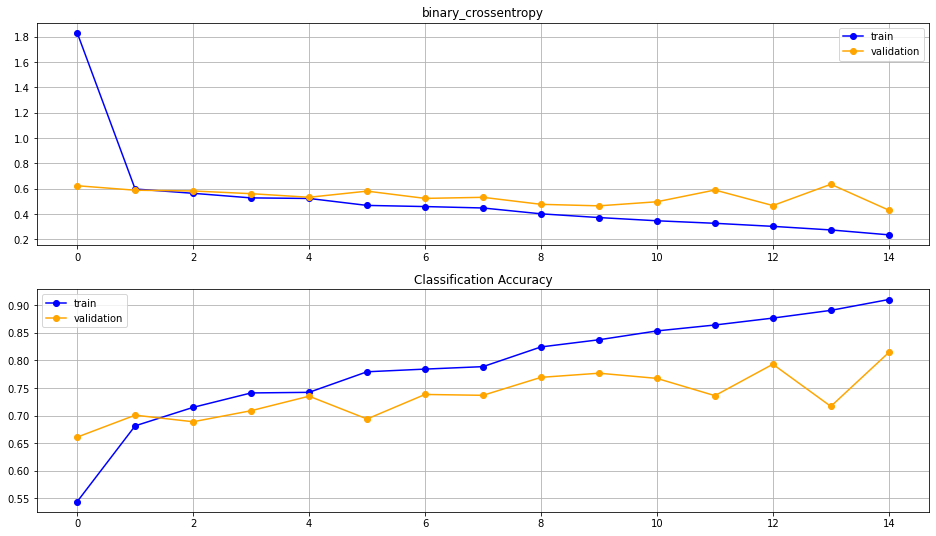

In [208]:
plot_history(history_2)

In [215]:
# modele article

In [216]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [220]:

model_cnn_3 = Sequential()
model_cnn_3.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))

model_cnn_3.add(tf.keras.layers.Conv2D(name = "conv2D",
                                       filters=32,
                                       kernel_size=(3,3),
                                       activation="relu",
                                       padding="same",
                                       ))
model_cnn_3.add(tf.keras.layers.MaxPooling2D(name="pooling",
                                             pool_size=(2,2)
                                            ))
model_cnn_3.add(tf.keras.layers.Conv2D(name = "conv2D_2",
                                       filters=64,
                                       kernel_size=(3,3),
                                       activation="relu",
                                       padding="same",
                                       ))
model_cnn_3.add(tf.keras.layers.MaxPooling2D(name="pooling_2",
                                             pool_size=(2,2)
                                            ))
model_cnn_3.add(tf.keras.layers.Conv2D(name="conv2D_3",
                                       filters=128,
                                       kernel_size=(3,3),
                                       activation="relu",
                                       padding="same",
                                      ))
model_cnn_3.add(tf.keras.layers.MaxPooling2D(name="pooling_3",
                                             pool_size=(2,2)
                                            ))
model_cnn_3.add(tf.keras.layers.Flatten(name="flatten"))
model_cnn_3.add(tf.keras.layers.Dense(name="dense_hidden",
                                      units = 512,
                                      activation="relu",
                                     ))
model_cnn_3.add(tf.keras.layers.Dropout(name="drop_1",
                                      rate=0.3,                                      
                                     ))
model_cnn_3.add(tf.keras.layers.Dense(name="dense_hidden_2",
                                      units = 512,
                                      activation="relu",
                                     ))
model_cnn_3.add(tf.keras.layers.Dropout(name="drop_2",
                                      rate=0.3,                                      
                                     ))
model_cnn_3.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))

In [221]:
# compiler modele
model_cnn_3.compile(optimizer = "adam", loss ="binary_crossentropy", metrics=["accuracy"])

In [222]:
model_cnn_3.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 32, 32, 32)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv2D_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
pooling_3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

In [223]:
history_3 = model_cnn_3.fit(X_train, y_train_enc,
                            epochs=EPOCHS, validation_data=(X_valid, y_valid_enc),
                            batch_size = BATCH_SIZE
                           )

Epoch 1/25
200/200 [==============================] - 104s 501ms/step - loss: 0.4808 - accuracy: 0.7316 - val_loss: 0.1768 - val_accuracy: 0.9413
Epoch 2/25
200/200 [==============================] - 98s 490ms/step - loss: 0.1507 - accuracy: 0.9522 - val_loss: 0.1550 - val_accuracy: 0.9525
Epoch 3/25
200/200 [==============================] - 98s 492ms/step - loss: 0.1320 - accuracy: 0.9566 - val_loss: 0.1408 - val_accuracy: 0.9584
Epoch 4/25
200/200 [==============================] - 101s 504ms/step - loss: 0.1167 - accuracy: 0.9616 - val_loss: 0.1313 - val_accuracy: 0.9597
Epoch 5/25
200/200 [==============================] - 99s 498ms/step - loss: 0.1050 - accuracy: 0.9637 - val_loss: 0.1563 - val_accuracy: 0.9478
Epoch 6/25
200/200 [==============================] - 99s 498ms/step - loss: 0.0923 - accuracy: 0.9687 - val_loss: 0.1438 - val_accuracy: 0.9575
Epoch 7/25
200/200 [==============================] - 109s 545ms/step - loss: 0.0776 - accuracy: 0.9734 - val_loss: 0.1708 - val

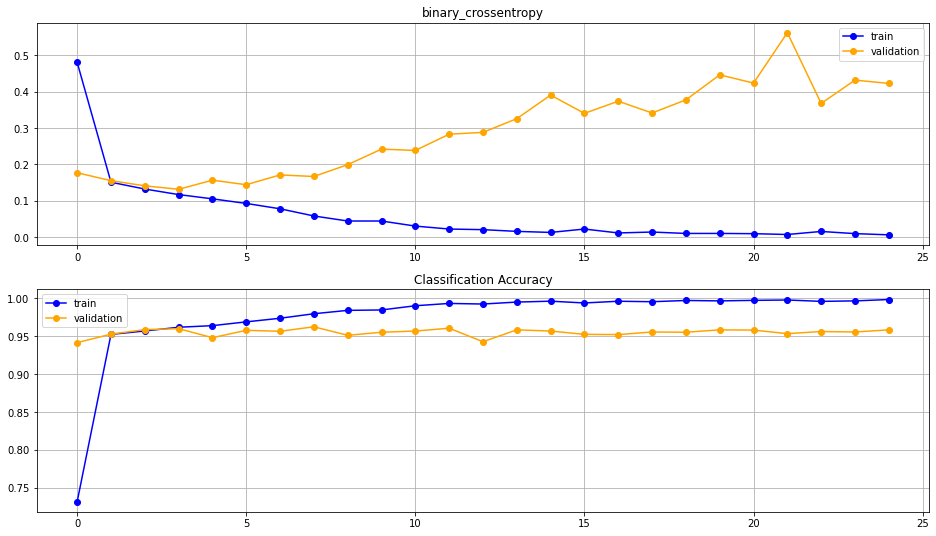

In [224]:
plot_history(history_3)